In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import itertools
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets, metrics, preprocessing
from sklearn.model_selection import GridSearchCV, learning_curve

%matplotlib inline

In [97]:

season_files = ['1993-1994.csv','1994-1995.csv','1995-1996.csv','1996-1997.csv','1997-1998.csv','1998-1999.csv','1999-2000.csv','2000-2001.csv','2001-2002.csv','2002-2003.csv','2003-2004.csv','2004-2005.csv','2005-2006.csv','2006-2007.csv','2007-2008.csv','2008-2009.csv','2009-2010.csv','2010-2011.csv','2011-2012.csv','2012-2013.csv','2013-2014.csv','2014-2015.csv','2015-2016.csv','2016-2017.csv']

path='.\Datasets\SerieA\\'

dfs = []


for file in season_files:

    df = pd.read_csv(path + file)
    cols= ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR'] 
    df = df[cols] 

    dfs.append(df)

    teams = {}

for season in range(len(dfs)):
    df = dfs[season]
    df['season']=season
    numteams=0
    for i in df.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
        numteams=numteams + 1
    nummatch = (numteams-1)*2
    inummatch= nummatch + 1
    totalmatch= int(nummatch*numteams/2)
    weekmatch=int(totalmatch/nummatch)


    df = get_gss(df, numteams, nummatch, inummatch, totalmatch)
    df = get_agg_points(df, numteams, nummatch, inummatch, totalmatch)
    df =add_form_df(df, numteams, nummatch, inummatch, totalmatch)

    dfs[season]=df

df=pd.concat(dfs)

In [96]:
# Gets the goals scored agg arranged by teams and matchweek
def get_goals_scored(playing_stat, numteams, nummatch, inummatch, totalmatch):
    # Create a dictionary with team names as keys
    teams = {}
  
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)  
    # Create a dataframe for goals scored where rows are teams and cols are mge(atchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,inummatch )]).T
    GoalsScored[0] = 0
    # Aggregate to get uptil that point
    for i in range(1,inummatch ):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored



# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat, numteams, nummatch, inummatch, totalmatch):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,inummatch)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(1,inummatch):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

def get_gss(playing_stat, numteams, nummatch, inummatch, totalmatch):

    GC = get_goals_conceded(playing_stat, numteams, nummatch, inummatch, totalmatch)
    GS = get_goals_scored(playing_stat, numteams, nummatch, inummatch, totalmatch)
   
    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(totalmatch):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])
        
        if ((i + 1)% 10) == 0:
            j = j + 1
        
    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC
    
    return playing_stat
    #playing_statistics = get_gss(playing_statistics, numteams, nummatch, inummatch, totalmatch)
   # print(playing_statistics)


In [13]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0
    

def get_cuml_points(matchres, numteams, nummatch, inummatch, totalmatch):  

    matchres_points = matchres.applymap(get_points)
    for i in range(2,inummatch):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]
        
    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(numteams)])
    return matchres_points


def get_matchres(playing_stat, numteams, nummatch, inummatch, totalmatch):
    # Create a dictionary with team names as keys
    teams = {}
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
   

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')
            
    return pd.DataFrame(data=teams, index = [i for i in range(1,inummatch)]).T

def get_agg_points(playing_stat, numteams, nummatch, inummatch, totalmatch):

    matchres = get_matchres(playing_stat, numteams, nummatch, inummatch, totalmatch)
    cum_pts = get_cuml_points(matchres, numteams, nummatch, inummatch, totalmatch)
    HTP = []
    ATP = []
    j = 0
    for i in range(totalmatch):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1
            
    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat
  

In [14]:
def get_form(playing_stat,num):
    form = get_matchres(playing_stat, numteams, nummatch, inummatch, totalmatch)
    form_final = form.copy()
    for i in range(num,inummatch):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1           
    return form_final

def add_form(playing_stat,num, numteams, nummatch, inummatch, totalmatch):
    form = get_form(playing_stat,num)
    h = ['M' for i in range(num * 10)]  # since form is not available for n MW (n*10)
    a = ['M' for i in range(num * 10)]
    
    j = num
    for i in range((num*10),totalmatch):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j]               # get past n results
        h.append(past[num-1])                    # 0 index is most recent
        
        past = form.loc[at][j]               # get past n results.
        a.append(past[num-1])                   # 0 index is most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HM' + str(num)] = h                 
    playing_stat['AM' + str(num)] = a

    
    return playing_stat

def add_form_df(playing_statistics, numteams, nummatch, inummatch, totalmatch):
    playing_statistics = add_form(playing_statistics,1, numteams, nummatch, inummatch, totalmatch)
    playing_statistics = add_form(playing_statistics,2, numteams, nummatch, inummatch, totalmatch)
    playing_statistics = add_form(playing_statistics,3, numteams, nummatch, inummatch, totalmatch)
    playing_statistics = add_form(playing_statistics,4, numteams, nummatch, inummatch, totalmatch)
    playing_statistics = add_form(playing_statistics,5, numteams, nummatch, inummatch, totalmatch)
    return playing_statistics  
# Make changes to df


In [5]:
def get_mw(playing_stat, numteams, nummatch, inummatch, totalmatch):
    j = 1
    MatchWeek = []
    for i in range(totalmatch):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat
    playing_statistics = get_mw(playing_statistics)
  

In [6]:
# Rearranging columns
cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
        'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5' ]

playing_statistics = playing_statistics[cols]

NameError: name 'playing_statistics' is not defined

In [59]:
playing_stat=df
# Gets the form points.
def get_form_points(string):
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

playing_stat['HTFormPtsStr'] = playing_stat['HM1'] + playing_stat['HM2'] + playing_stat['HM3'] + playing_stat['HM4'] + playing_stat['HM5']
playing_stat['ATFormPtsStr'] = playing_stat['AM1'] + playing_stat['AM2'] + playing_stat['AM3'] + playing_stat['AM4'] + playing_stat['AM5']

playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

# Identify Win/Loss Streaks if any.
def get_3game_ws(string):
    if string[-3:] == 'WWW':
        return 1
    else:
        return 0
    
def get_5game_ws(string):
    if string == 'WWWWW':
        return 1
    else:
        return 0
    
def get_3game_ls(string):
    if string[-3:] == 'LLL':
        return 1
    else:
        return 0
    
def get_5game_ls(string):
    if string == 'LLLLL':
        return 1
    else:
        return 0
    
playing_stat['HTWinStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ws)
playing_stat['HTWinStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ws)
playing_stat['HTLossStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ls)
playing_stat['HTLossStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ls)

playing_stat['ATWinStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ws)
playing_stat['ATWinStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ws)
playing_stat['ATLossStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ls)
playing_stat['ATLossStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ls)

playing_stat.keys()

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'season', 'HTGS',
       'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'AM1', 'HM2', 'AM2', 'HM3',
       'AM3', 'HM4', 'AM4', 'HM5', 'AM5', 'HTFormPtsStr', 'ATFormPtsStr',
       'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5',
       'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
       'ATLossStreak3', 'ATLossStreak5'],
      dtype='object')

In [60]:
# Get Goal Difference
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']

# Diff in points
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']

<AxesSubplot:>

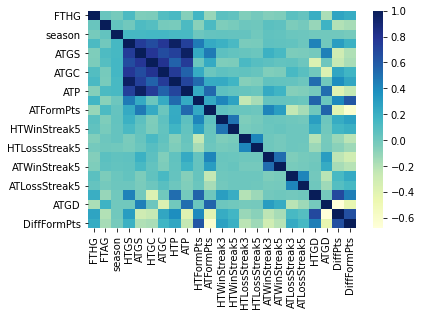

In [61]:
corr =df.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=False)

In [62]:
tr_split = 0.7


# Calculate train/test size
rows, cols = df.shape
tr_size = int(rows*tr_split)
te_size = rows - tr_size

# Split dataset
train_df = df.iloc[:tr_size]
test_df = df.iloc[tr_size:]

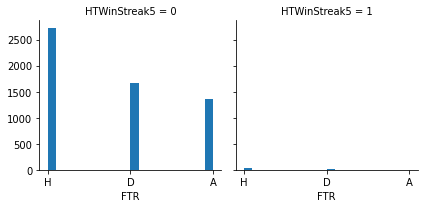

In [63]:
g = sns.FacetGrid(train_df, col='HTWinStreak5')
_ = g.map(plt.hist, 'FTR', bins=20)

In [79]:
#DATA PREPROCESSING
features = ['HomeTeam', 'AwayTeam', 'DiffPts', 'ATWinStreak5', 'ATWinStreak3', 'HTWinStreak5', 'HTWinStreak3','DiffFormPts','DiffPts']
y_target = 'FTR'


# Drop rows with nan
data = df.dropna()

for col in ['HomeTeam', 'AwayTeam']:

    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

x = data[features]
y = data['FTR']

# x = bundesliga.drop('FTR',axis=1)
# y = bundesliga['FTR']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(None)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [89]:
 #CLASSIFIER
rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(x_train, y_train) 
y_pred=rfc.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.39      0.34      0.37       416
           D       0.27      0.19      0.22       467
           H       0.55      0.69      0.61       779

    accuracy                           0.46      1662
   macro avg       0.40      0.41      0.40      1662
weighted avg       0.43      0.46      0.44      1662

[[142 109 165]
 [113  90 264]
 [107 138 534]]


Accuracy 46.09
Normalized confusion matrix


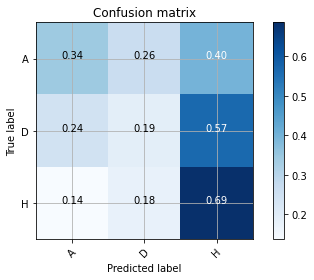

In [90]:
cm = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy %.2f" % (accuracy*100))
plot_confusion_matrix(cm, classes= ['A', 'D','H'], normalize=True)

In [91]:
#SVM
svc = SVC()
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.50      0.27      0.36       416
           D       0.00      0.00      0.00       467
           H       0.51      0.94      0.66       779

    accuracy                           0.51      1662
   macro avg       0.34      0.40      0.34      1662
weighted avg       0.36      0.51      0.40      1662

[[114   0 302]
 [ 64   0 403]
 [ 48   0 731]]
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Accuracy 50.84
Normalized confusion matrix


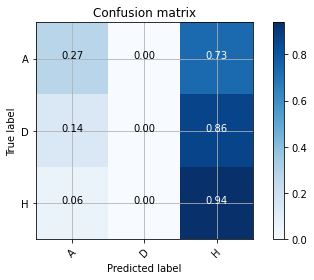

In [92]:
cm = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy %.2f" % (accuracy*100))
plot_confusion_matrix(cm, classes= ['A', 'D','H'], normalize=True)

In [93]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.35      0.35      0.35       416
           D       0.29      0.30      0.30       467
           H       0.53      0.53      0.53       779

    accuracy                           0.42      1662
   macro avg       0.39      0.39      0.39      1662
weighted avg       0.42      0.42      0.42      1662

[[144 119 153]
 [122 141 204]
 [147 222 410]]


Accuracy 41.82
Normalized confusion matrix


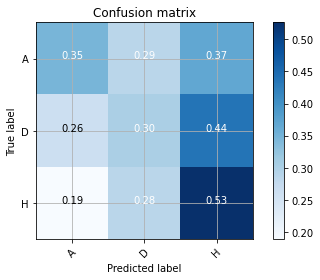

In [94]:
cm = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy %.2f" % (accuracy*100))
plot_confusion_matrix(cm, classes= ['A', 'D','H'], normalize=True)

In [88]:
df.to_csv("SerieApreprocesada.csv")